# Image Segmentation Laboratory

1695 2D multi-channel brain MR images were collected from the Brain Tumor Segmentation ([BraTS](http://braintumorsegmentation.org/)) Challenge 2020 training set.
Each available file here contains 4 MR images (T1, T2, T1ce, and FLAIR), and its true segmentation.

The aim of this assignment is to develop a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) convolutional neural network able to segment and highlight the brain tumour from such images.

Let's start making sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

########## YOUR CODE ############
from google.colab import drive
drive.mount('/content/drive')
#%cd /content/drive/My\ Drive/Colab\ Notebooks
#%%writefile utils.py
!wget -O seg_lab.zip https://tiny.cc/vxt7gz
!unzip seg_lab.zip;
#!conda env create -f env.ymlNN #conda: command not found
##########    END    ############

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive
--2021-07-20 07:19:26--  https://tiny.cc/vxt7gz
Resolving tiny.cc (tiny.cc)... 157.245.113.153
Connecting to tiny.cc (tiny.cc)|157.245.113.153|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://liuonline-my.sharepoint.com/:u:/g/personal/davab27_liu_se/ESibIRhFBoZFt07YBsvwt9QBlDQfyFC_py9Q8SpF3hRQmA?download=1 [following]
--2021-07-20 07:19:27--  https://liuonline-my.sharepoint.com/:u:/g/personal/davab27_liu_se/ESibIRhFBoZFt07YBsvwt9QBlDQfyFC_py9Q8SpF3hRQmA?download=1
Resolving liuonline-my.sharepoint.com (liuonline-my.sharepoint.com)... 52.105.29.53
Connecting to liuonline-my.sharepoint.com (liuonline-my.sharepoint.com)|52.105.29.53|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/davab27_liu_se/Documents/seg_lab.zip?originalPath=aHR0cHM6Ly9saXVvbmxpbmUtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWw

## Load data
Open the file `utils.py` and get familiar with its functions.

The images are saved as `.npy` files in the folder `Data2D_BRATS_multiseg`. 
Each file contains 5 channels:
- channels 0 to 3 contain T1, T2, T1ce, and FLAIR modalities;
- channel 4 contains the true segmentation.

Use the functions `load_img()` and `visualize()` in `utils.py` to load and visualize one image.

/content/drive/My Drive/Colab Notebooks
The image dataset contatins: 1695 images.


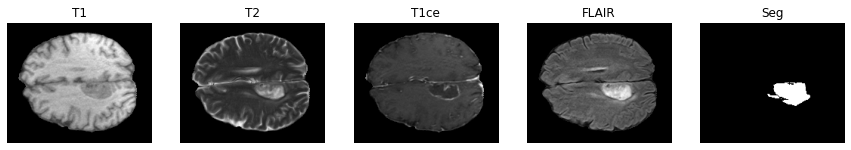

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


In [117]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
from utils import * 
import numpy as np
import matplotlib.pyplot as plt
import glob

Nclasses = 2
list_images = sorted(glob.glob('./Data2D_BRATS_multiseg/*.npy'))
Nim = len(list_images)

print('The image dataset contatins: {} images.'.format(Nim))
########## YOUR CODE ############
[x,seg_load] = load_img(list_images[500],Nclasses)
visualize(x,seg_load)
print(x)
##########    END    ############

##  Split data into training, validation and testing

We will use the `DataGenerator` class to feed the images to the model during training. This class streams the data directly from the `.npy` files, so we do not need to load the images explicitly. Therefore, we will work with the file list instead, stored in `list_images`.

Split `list_images` into training (`list_train`), validation (`list_valid`) and testing (`list_test`) indexes sets such as they are approximately the 70%, 20%, and 10% of the whole list, using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Use them to create 3 `DataGenerators`, one for each different set, with the default options.

In [99]:
from sklearn.model_selection import train_test_split
########## YOUR CODE ############
# split the data
lst, list_valid = train_test_split(list_images,test_size=0.2,train_size=0.8,random_state = 42) #lst = 4/5 of imgs
list_train, list_test = train_test_split(lst, test_size = 0.125, train_size = 0.875) #5/4*(1/10) = 12.5
# create the three generators
train_gen = DataGenerator(list_train,Nclasses)
valid_gen = DataGenerator(list_valid, Nclasses)
test_gen = DataGenerator(list_test, Nclasses)
##########    END    ############

Ntrain = len(list_train)
Nvalid = len(list_valid)
Ntest = len(list_test)

print('The training, validation, and testing set have {} ({:.2f}%), {} ({:.2f}%) and {} ({:.2f}%) images respectively.'
      .format(Ntrain, 100*Ntrain/Nim, Nvalid, 100*Nvalid/Nim, Ntest, 100*Ntest/Nim))

The training, validation, and testing set have 1186 (69.97%), 339 (20.00%) and 170 (10.03%) images respectively.


### Data visualization
Let's use now the `DataGenerator` class to load and visualize a batch of data.

- `len(DataGenerator)` returns the lenghts of the generator, that is the total number of batches;
- `DataGenerator[i]` returns the i-th batch.

An image batch has shape: (8, 160, 192, 4)
A target batch has shape: (8, 160, 192, 2)


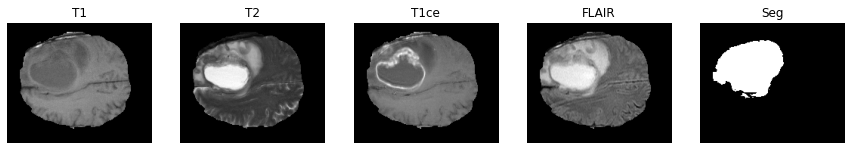

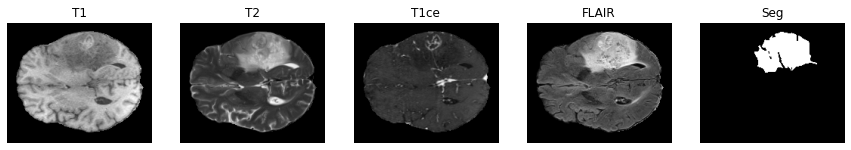

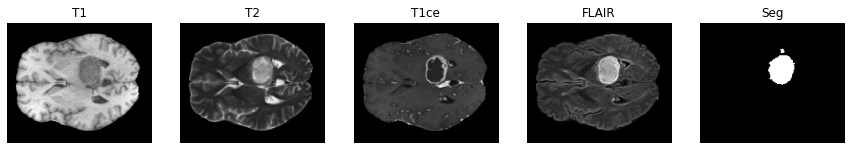

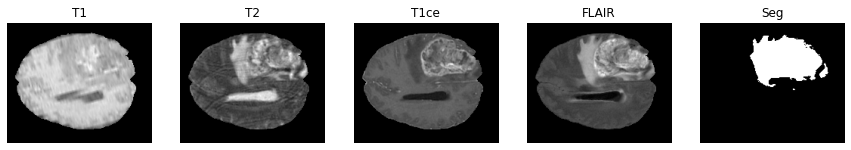

In [100]:
# choose a random batch index
idx = np.random.randint(len(train_gen))

# load the idx-th batch
Xbatch, ybatch = train_gen[idx]
print('An image batch has shape: {}'.format(Xbatch.shape))
print('A target batch has shape: {}'.format(ybatch.shape))

# visualize few data samples 
for i in range(4):
    visualize(Xbatch[i], ybatch[i])

## Balance the classes

Extract and print here below the class weights that belong to the training set using the function:

`class_weights = n_samples / (n_classes * np.bincount(y))`.

Pay attention that the `np.bincount(y))` function wants its input as a flattened array and its elements as integers. In order to speed up the calculation, you can calculate the paramenters just on the first 10, 20 or 30 batches.

In the end, store the weights in `class_weights` and convert them into `float32` dtype to be used properly in the training process.

In [98]:
Y = []
n = 0

for _, ybatch in train_gen:

    # concatenate in Y the n-th flattened target batch
    Y = np.concatenate((Y, np.argmax(ybatch, axis=-1).flatten()))
    
    # interrupt the cycle
    n += 1
    if n == 30:
        break

Y = Y.astype('int64')

########## YOUR CODE ############
# calcuate the class weights
class_weights = n/(Nclasses*np.bincount(Y))
class_weights = np.float32(class_weights)
##########    END    ############

print('The class weights for the four different classes are respectively:\n{}'.format(class_weights))
print(class_weights.dtype)
print(np.bincount(Y))

The class weights for the four different classes are respectively:
[2.2069773e-06 1.0623605e-04 5.4905435e-05 9.2717361e-05]
float32
[6796626  141195  273197  161782]


<b>Question:</b> What can you say about the class weights just calculated? Are they as you expected? 

<b>Answer:</b> Since the weights are supposed to counter balance the effect of uneven pixel count across images this would need to be held against the pixel count for these images. I suppose this is what np.bincount(Y) does and thereby the formula makes more sense.

## Pre-processing
Perform image normalization only on the brain area (the background must stay with 0 value), tips at [link](http://cs231n.github.io/neural-networks-2/)). 

Complete the function `norm_brain` in `utils.py`. Then, create new `DataGenerator` objects, setting `norm=True`. Set also `batch_size=1` for the test `DataGenerator` only.

Afterwards, plot a few normalized images to see the difference.

TypeError: ignored

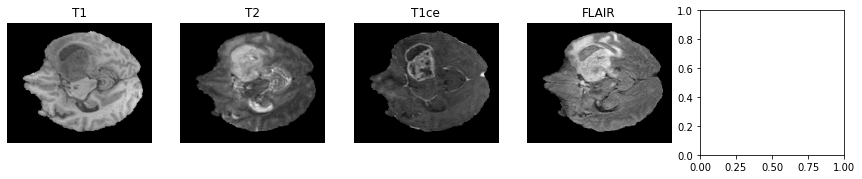

In [132]:
########## YOUR CODE ############

#for i in range(Nim)
#img_normed = norm_brain(load_img(list_images[i],Nclasses))
temp_img = load_img(list_images[1],Nclasses);
visualize(temp_img[0],_)
#send temp_img[0] to norm_brain.? return a normalized image and what then?



#use these in DataGenerators?

#lst_images_norm = np.std(list_images,axis = 0)
# create new DataGenerators

# visualize a few data samples

##########    END    ############

## U-Net
Finish this code to create the U-Net architecture.

Relevant [Keras](https://www.tensorflow.org/api_docs/python/tf/keras) layers are:

`Conv2D`, performs 2D convolutions with a number of filters with a certain size. Use `he_normal` weights initialization, and `same` padding;

`BatchNormalization`, normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1;

`Activation`, i.e. `relu` activation function sets to 0 all the negatives values;

`MaxPool2D`, saves the max for a given pool size, results in down sampling;

`Conv2DTranspose`, increases the resolution by a certain factor, through interpolation;

`Dropout`, randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting.

`concatenate`, concatenate a list of inputs.

Moreover, the useful list methods for this lab are:

`.append()`, adds an element to the end of a list;

`.pop()`, gets an element from the end of a list.

![Unet architecture](https://github.com/jespervc/budgetsegmentation/blob/main/Unet_architecture.png?raw=1)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPool2D, Conv2DTranspose, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

class UNet(object):
    
    def __init__(self, img_size, Nclasses, class_weights, model_name='myWeights.h5', Nfilter_start=64, depth=3):
        self.img_size = img_size
        self.Nclasses = Nclasses
        self.class_weights = class_weights
        self.model_name = model_name
        self.Nfilter_start = Nfilter_start
        self.depth = depth

        inputs = Input(img_size)
    
        def dice(y_true, y_pred, w=self.class_weights):
            y_true = tf.convert_to_tensor(y_true, 'float32')
            y_pred = tf.convert_to_tensor(y_pred, 'float32')

            num = 2 * tf.reduce_sum(tf.reduce_sum(y_true*y_pred, axis=[0,1,2])*w)
            den = tf.reduce_sum(tf.reduce_sum(y_true+y_pred, axis=[0,1,2])*w) + 1e-5

            return num/den

        def diceLoss(y_true, y_pred):
            return 1-dice(y_true, y_pred)
        
        
        ########## YOUR CODE ############
        
        # This is a help function that performs 2 convolutions, each followed by batch normalization
        # and ReLu activations, Nf is the number of filters, filter size (3 x 3)
        def convs(layer, Nf):
            
            return x
            
        # This is a help function that defines what happens in each layer of the encoder (downstream),
        # which calls "convs" and then Maxpooling (2 x 2). Save each layer for later concatenation in the upstream.
        def encoder_step(layer, Nf):
            
            return y, x
            
        # This is a help function that defines what happens in each layer of the decoder (upstream),
        # which contains upsampling (2 x 2), 2D convolution (2 x 2), batch normalization, concatenation with 
        # corresponding layer (y) from encoder, and lastly "convs"
        def decoder_step(layer, layer_to_concatenate, Nf):
            
            return x
        
        layers_to_concatenate = []
        x = inputs
        
        # Make encoder with 'self.depth' layers, 
        # note that the number of filters in each layer will double compared to the previous "step" in the encoder
        for d in range(self.depth-1):
            
            
            
        # Make bridge, that connects encoder and decoder using "convs" between them. 
        # Use Dropout before and after the bridge, for regularization. Use drop probability of 0.2.
        
        
        
        # Make decoder with 'self.depth' layers, 
        # note that the number of filters in each layer will be halved compared to the previous "step" in the decoder
        for d in range(self.depth-2, -1, -1):
            
            
        ##########    END    ############
        
        # Make classification (segmentation) of each pixel, using convolution with 1 x 1 filter
        final = Conv2D(filters=self.Nclasses, kernel_size=(1,1), activation = 'softmax')(x)
        
        # Create model
        self.model = Model(inputs=inputs, outputs=final)
        self.model.compile(loss=diceLoss, optimizer=Adam(lr=1e-4), metrics=['accuracy',dice]) 
        
    def train(self, train_gen, valid_gen, nEpochs):
        print('Training process:')       
        callbacks = [ModelCheckpoint(self.weights_name, save_best_only=True, save_weights_only=True),
                     EarlyStopping(patience=10)]
        
        history = self.model.fit(train_gen, validation_data=valid_gen, epochs=nEpochs, callbacks=callbacks)

        return history    
    
    def evaluate(self, test_gen):
        print('Evaluation process:')
        loss, acc, dice = self.model.evaluate(test_gen)
        print('Accuracy: {:.4f}'.format(acc*100))
        print('Dice: {:.4f}'.format(dice*100))
        return acc, dice
    
    def predict(self, X):
        y_pred = self.model.predict(X)
        return y_pred
    
    def calculate_metrics(self, y_true_flat, y_pred_flat):
        ########## YOUR CODE ############
        # be sure that the inputs are binary.
        # calculate the confusion matrix using tf.math.confusion_matrix()

        # calculate the accuracy and Dice using. 
        # Set to np.nan the value for Dice when the confusion matrix has only true negatives.
    
        return 0, 0
        
        ##########    END    ############
    
    def get_metrics(self, generator):
        ''' This function calculates the metrics accuracy and Dice for each image contained in the input generator.
        '''
        Nim = len(generator)*generator.batch_size
        ACC = np.empty((Nim, self.Nclasses))
        DICE = np.empty((Nim, self.Nclasses))
        n = 0
        for i in range(len(generator)):
            X_batch, y_batch = generator[i]
            y_pred = self.model.predict(X_batch)
            y_pred = to_categorical(tf.argmax(y_pred, axis=-1), self.Nclasses)

            for c in range(Nclasses):
                y_true_flat = tf.reshape(y_batch[0,:,:,c], (160*192,))
                y_pred_flat = tf.reshape(y_pred[0,:,:,c], (160*192,))              

                acc, dice = self.calculate_metrics(y_true_flat, y_pred_flat)
                ACC[n,c] = acc
                DICE[n,c] = dice

            n+=1

        return ACC, DICE

### Visualize the network
Initialize your U-Net `net` and print out the model using `net.model.summary()`.
If it prints out error you may have implemented the architecture incorrectly.

In [ ]:
img_size = (160, 192, 4)
net = UNet(img_size, Nclasses, class_weights, weights_name='myWeights_multiseg.h5')
net.model.summary()

If you could print the summary, then you can also visualize the network

### Train the network

Use the method `train()`of the `UNet` class to train your network.

In [ ]:
results = net.train(train_gen, valid_gen, nEpochs=3)

Now use the function `plot_trends()`in `utils.py` to visualize the accuracy, dice, and dice loss trends dunring the training epochs. 

In [ ]:
plot_trends(results)

### Evaluate the network
Use the method `evaluate()` of the `UNet` class to calculate the mean performance of the network on the test set.

Compleate the method `calculate_metrics()` used in `get_metrics()` in the `UNet` class to calcualte the accuracy and Dice score per each class.

In [ ]:
acc, dice = net.evaluate(test_gen)
ACC, DICE = net.get_metrics(test_gen)
     
ACC_avg = np.nanmean(ACC, axis=0)
DICE_avg = np.nanmean(DICE, axis=0)
ACC_std = np.nanstd(ACC, axis=0)
DICE_std = np.nanstd(DICE, axis=0)

print('\nThe network detects:')
for c in range(Nclasses):
    print('- class {} with accuracy: {:.4f} +/- {:.4f}, and dice score: {:.4f} +/- {:.4f}'
          .format(c, ACC_avg[c], ACC_std[c], DICE_avg[c], DICE_std[c]))

**Question:** Do you see any differences? Can you explain why?

**Answer:**

### Visualize predictions

In [ ]:
idx = np.random.randint(len(test_gen))
X_batch, y_batch = test_gen[idx]
y_pred = net.predict(X_batch)
y_pred = to_categorical(np.argmax(y_pred, axis=-1), Nclasses)

print('TRUE')
visualize(X_batch[0], y_batch[0])
print('PREDICTION')
visualize(X_batch[0], y_pred[0])

print('This segmentation prediction has:')
for c in range(Nclasses):
    y_true_flat = tf.reshape(y_batch[0,:,:,c], (160*192,))
    y_pred_flat = tf.reshape(y_pred[0,:,:,c], (160*192,))
    
    acc, dice = net.calculate_metrics(y_true_flat, y_pred_flat)
    print('- class {} with accuracy: {:.4f}, and dice score: {:.4f}'
          .format(c, acc, dice))

## Image Augmentation

Before start using the `DataGenerator` for the augmentation, let's get familiar with the techniques we are going to use.

### Flipping
A very easy and used augmentation technique is flipping. 
The output image is simply the reflection of the original one along one of the two main axis, so the image can be flipped from left to right or up and down. Luckily for you, [`tf.image`](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/image) provides this function. 

In [ ]:
from tensorflow.image import flip_left_right, flip_up_down

idx = np.random.randint(len(train_gen))
Xbatch, ybatch = train_gen[idx]
im, gt = Xbatch[0], ybatch[0]

im_lr, gt_lr = flip_left_right(im), flip_left_right(gt)
im_ud, gt_ud = flip_up_down(im), flip_up_down(gt)

print('TRUE')
visualize(im, gt)
print('LEFT-RIGHT')
visualize(im_lr, gt_lr)
print('UP-DOWN')
visualize(im_ud, gt_ud)

### Affine Transormation
Affine transformation is that trasformation that takes into account translation, rotation, shear and zoom spatial transformation at the same time. 

Luckily for us, Keras provides such function: [`tf.keras.preprocessing.image`](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/preprocessing/image).

In [ ]:
from tensorflow.keras.preprocessing.image import apply_affine_transform

rows, columns, channels = im.shape

########## YOUR CODE ############
# try some parameters:
# rotation angle 
alpha = 0

# number of pixels to shift the image along the 2 axis
Tx, Ty = 0, 0

# shear angle in degrees
beta = 0

# zoom percentage to impose alog the 2 axis
Zx, Zy = 1, 1
##########    END    ############

print('The augmentation is goint to use:')
print('  - Rotation of {:.2f} degrees;'.format(alpha))
print('  - Translation of {} and {} along the x and y axis respectively;'.format(Tx, Ty))
print('  - Shear of {:.2f} degrees;'.format(beta))
print('  - Zoom of {:.2f} and {:.2f} along the x and y axis respectively.'.format(Zx, Zy))
print(' ')

# apply affine tranformation to the image
im2 = apply_affine_transform(im, 
                             theta=alpha,      # rotation
                             tx=Tx, ty=Ty,     # translation
                             shear=beta,       # shear
                             zx=Zx, zy=Zy,     # zoom
                             row_axis=0, col_axis=1, channel_axis=2, 
                             fill_mode='constant', cval=0.0, 
                             order=1)

# apply affine tranformation to the target
gt2 = apply_affine_transform(gt, 
                             theta=alpha,      # rotation
                             tx=Tx, ty=Ty,     # translation
                             shear=beta,       # shear
                             zx=Zx, zy=Zy,     # zoom
                             row_axis=0, col_axis=1, channel_axis=2, 
                             fill_mode='constant', cval=0.0, 
                             order=0)

print('TRUE')
visualize(im, gt)
print('AUGMENTED')
visualize(im2, gt2)

Now that you got familiar with such functions, edit the `augmentation()` function in `utils.py`.

The function takes as input one multi-channel MRI, its segmentation and an array `do` made of 0s and 1s. It applies the $i$-th augmentation technique if `do[i] == 1`, otherwise it does not.

Once you have completed this task, create a training and validation `DataGenerator`s (`train_gen_aug` and `valid_gen_aug`) that apply image normalization and augmentation. So, the generators should have as inputs: `norm=True` and `augmentation=True`.

Visualize also a few samples to understand better what is going on.

In [ ]:
########## YOUR CODE ############
# create new DataGenerators

# visualize a few data samples

##########    END    ############

### Train the network

In [ ]:
net2 = unet(img_size, Nclasses, class_weights, weights_name='myWeightsAug_multiseg.h5')
results = net2.train(train_gen_aug, valid_gen_aug, nEpochs=5)

In [ ]:
plot_trends(results)

### Evaluate the network

In [ ]:
acc, dice = net2.evaluate(test_gen)
ACC, DICE = net2.get_metrics(test_gen)

ACC_avg = np.nanmean(ACC, axis=0)
DICE_avg = np.nanmean(DICE, axis=0)
ACC_std = np.nanstd(ACC, axis=0)
DICE_std = np.nanstd(DICE, axis=0)

print('\nThe network detects:')
for c in range(Nclasses):
    print('- class {} with accuracy: {:.4f} +/- {:.4f}, and dice score: {:.4f} +/- {:.4f}'
          .format(c, ACC_avg[c], ACC_std[c], DICE_avg[c], DICE_std[c]))

### Visualize predictions

In [ ]:
idx = np.random.randint(len(test_gen))
X_batch, y_batch = test_gen[idx]
y_pred = net.predict(X_batch)
y_pred = to_categorical(np.argmax(y_pred, axis=-1), Nclasses)

print('TRUE')
visualize(X_batch[0], y_batch[0])
print('PREDICTION')
visualize(X_batch[0], y_pred[0])

print('This segmentation prediction has:')
for c in range(Nclasses):
    y_true_flat = tf.reshape(y_batch[0,:,:,c], (160*192,))
    y_pred_flat = tf.reshape(y_pred[0,:,:,c], (160*192,))
    
    acc, dice = net.calculate_metrics(y_true_flat, y_pred_flat)
    print('- class {} with accuracy: {:.4f}, and dice score: {:.4f}'
          .format(c, acc, dice))

**Question:** Based on your quantitative and qualitative results, do you think it is better training with or without augmentation?

**Answer:**

## Multi-class segmentation (optional)
Implement multi-class segmentaiton for brain tumors. Set `Nclasses=4` at the beginning of the main code.